In [2529]:
import os
import scanpy as sc

home = '/home/kojo/Code/temporary-trvae-clone'
os.chdir(home)

In [2530]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import reptrvae

In [2531]:
adata = sc.read('./data/alzPro_count.h5ad')
adata

AnnData object with n_obs × n_vars = 48 × 2969
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'Validation'

In [2532]:
adata.obs['Group'].value_counts()

HET    24
WT     24
Name: Group, dtype: int64

In [2533]:
#sc.pp.normalize_per_cell(adata)
sc.pp.normalize_total(adata, target_sum=1000)
#sc.pp.log1p(adata, base=np.e)
#sc.pp.log1p(adata, base=1000)
#sc.pp.highly_variable_genes(adata, n_top_genes=500)

In [2534]:
#adata = adata[:, adata.var['highly_variable']]

In [2535]:
adata.X.min(), adata.X.max()

(0.0, 55.11332)

In [2536]:
adata.obs['Timepoint'].value_counts()

3m    16
6m    16
9m    16
Name: Timepoint, dtype: int64

In [2537]:
adata.obs['Validation'].value_counts()

Train    36
Test     12
Name: Validation, dtype: int64

In [2538]:
os.makedirs("./data/", exist_ok=True)

In [2539]:
adata.write_h5ad("./data/alzPro_normalized.h5ad")

In [2540]:
special_cell_type = "Test"

In [2541]:
cell_type_adata = adata[adata.obs["Validation"] == special_cell_type]

In [2542]:
cell_type_adata.obs['Group'].value_counts()

HET    6
WT     6
Name: Group, dtype: int64

In [2543]:
cell_type_adata.obs['Group'].cat.categories

Index(['HET', 'WT'], dtype='object')

In [2544]:
sc.tl.rank_genes_groups(cell_type_adata, groups=['HET'], groupby="Group", reference='WT', n_genes=10)

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [2545]:
top_genes = cell_type_adata.uns['rank_genes_groups']['names']['HET']
top_genes

array(['P20060|HEXB', 'P47963|RL13', 'P52760|RIDA', 'O35874|SATT',
       'P20152|VIME', 'P26443|DHE3', 'Q920E5|FPPS', 'P08226|APOE',
       'Q9R0P5|DEST', 'O89051|ITM2B'], dtype=object)

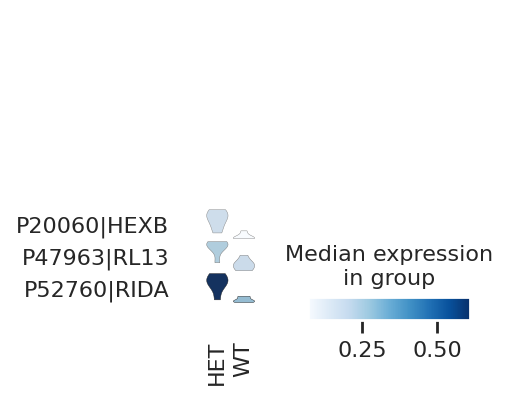

In [2546]:
sc.pl.stacked_violin(cell_type_adata, groupby='Group', var_names=top_genes[:3], swap_axes=True)

## Viewing Results

In [2547]:
import os
import scanpy as sc

home = '/home/kojo/Code/temporary-trvae-clone'
os.chdir(home)

In [2548]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from scipy import sparse
from scipy import stats
from matplotlib import pyplot as plt
import reptrvae

In [2549]:
sc.set_figure_params(dpi=200)

In [2550]:
path_to_save = "./results/alzPro/"
sc.settings.figdir = path_to_save

In [2551]:
specific_cell_type = "HET"
#specific_cell_type = "Test"

In [2552]:
cell_type_key = "Group"
condition_key = "Timepoint"
source_condition = "3m"
target_condition = "9m"
conditions = ['3m', '6m', "9m"]
#conditions = ['WT', 'HET']

In [2553]:
#mode = 'normalized'
mode = 'count'
adata = sc.read(f"./data/alzPro_{mode}.h5ad")
#adata.uns['log1p']["base"] = None
adata

AnnData object with n_obs × n_vars = 48 × 2969
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'Validation'

In [2554]:
adata.X.min(), adata.X.max()

(0.0, 443000000.0)

In [2555]:
adata.X[0][1550]

429000.0

In [2556]:
adata = adata[adata.obs[condition_key].isin(conditions)]

In [2557]:
adata.X[0][1550]

429000.0

In [2558]:
cell_type_adata = adata[adata.obs[cell_type_key] == specific_cell_type]
#cell_type_adata.uns['log1p']["base"] = None
cell_type_adata

View of AnnData object with n_obs × n_vars = 24 × 2969
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'Validation'

In [2559]:
cell_type_adata.X[0][1550]

429000.0

In [2560]:
ctrl_adata = cell_type_adata[cell_type_adata.obs[condition_key] == source_condition]
real_adata = cell_type_adata[cell_type_adata.obs[condition_key] == target_condition]

In [2561]:
ctrl_adata.obs['method'] = source_condition
real_adata.obs['method'] = target_condition

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.
/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


In [2562]:
trvae_reconstructed = sc.read(f"./data/reconstructed/trVAE_alzProTime/{specific_cell_type}.h5ad")
#trvae_reconstructed.uns['log1p']["base"] = None
trvae_reconstructed

AnnData object with n_obs × n_vars = 16 × 2969
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'Validation', 'batch'

In [2563]:
trvae_reconstructed.X[0][1550]

465534.97

In [2564]:
trvae_reconstructed.X[:8].min(), trvae_reconstructed.X[:8].max()

(0.0, 7191220.5)

In [2565]:
trvae_reconstructed.obs

,Qi ID,sex,Group,Timepoint,Validation,batch
0-0,3131,M,HET,3m_to_9m,Test,0
1-0,3132,M,HET,3m_to_9m,Train,0
2-0,3140,M,HET,3m_to_9m,Train,0
3-0,3141,M,HET,3m_to_9m,Train,0
4-0,3153,F,HET,3m_to_9m,Test,0
5-0,3154,F,HET,3m_to_9m,Train,0
6-0,3156,F,HET,3m_to_9m,Train,0
7-0,3157,F,HET,3m_to_9m,Train,0
32-1,2143,M,HET,9m,Test,1
33-1,2145,M,HET,9m,Train,1


In [2566]:
trvae_pred = trvae_reconstructed[trvae_reconstructed.obs[condition_key] == f"{source_condition}_to_{target_condition}"]
trvae_pred.var = ctrl_adata.var
trvae_pred.obs['method'] = 'trVAE'

In [2567]:
trvae_pred.obs

,Qi ID,sex,Group,Timepoint,Validation,batch,method
0-0,3131,M,HET,3m_to_9m,Test,0,trVAE
1-0,3132,M,HET,3m_to_9m,Train,0,trVAE
2-0,3140,M,HET,3m_to_9m,Train,0,trVAE
3-0,3141,M,HET,3m_to_9m,Train,0,trVAE
4-0,3153,F,HET,3m_to_9m,Test,0,trVAE
5-0,3154,F,HET,3m_to_9m,Train,0,trVAE
6-0,3156,F,HET,3m_to_9m,Train,0,trVAE
7-0,3157,F,HET,3m_to_9m,Train,0,trVAE


In [2568]:
models = ctrl_adata.concatenate(real_adata, trvae_pred)
models.obs['method'].unique()

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


array(['3m', '9m', 'trVAE'], dtype=object)

In [2569]:
models.var_names

Index(['A2A432|CUL4B', 'A2A5R2|BIG2', 'A2A699|F1712', 'A2A7S8|K1522',
       'A2A8L1|CHD5', 'A2A8L5|PTPRF', 'A2ADY9|DDI2', 'A2AG50|MA7D2',
       'A2AGT5|CKAP5', 'A2AJA9|AJM1',
       ...
       'Q9Z2U0|PSA7', 'Q9Z2U1|PSA5', 'Q9Z2U2|ZN292', 'Q9Z2V5|HDAC6',
       'Q9Z2W0|DNPEP', 'Q9Z2W8|GRIA4', 'Q9Z2W9|GRIA3', 'Q9Z2X1|HNRPF',
       'Q9Z2Y3|HOME1', 'Q9Z2Y8|PLPHP'],
      dtype='object', name='Accession', length=2969)

In [2570]:
sc.tl.rank_genes_groups(models, reference=target_condition, 
                       groupby="method", groups=['trVAE'],
                       key_added='up_reg_genes', n_genes=50)
sc.tl.rank_genes_groups(models, reference='trVAE',
                         groupby="method", groups=[target_condition],
                         key_added='down_reg_genes', n_genes=50)
up_genes = models.uns['up_reg_genes']['names']['trVAE']
down_genes = models.uns['down_reg_genes']['names'][target_condition]

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: invalid value encountered in true_divide
  self.expm1_func(mean_rest) + 1e-9


In [2571]:
models.obs

,Qi ID,sex,Group,Timepoint,Validation,method,batch
0-0,3131,M,HET,3m,Test,3m,0
1-0,3132,M,HET,3m,Train,3m,0
2-0,3140,M,HET,3m,Train,3m,0
3-0,3141,M,HET,3m,Train,3m,0
4-0,3153,F,HET,3m,Test,3m,0
5-0,3154,F,HET,3m,Train,3m,0
6-0,3156,F,HET,3m,Train,3m,0
7-0,3157,F,HET,3m,Train,3m,0
32-1,2143,M,HET,9m,Test,9m,1
33-1,2145,M,HET,9m,Train,9m,1


In [2572]:
protein_up = up_genes[0]
print(protein_up)

Q8K2C6|SIR5


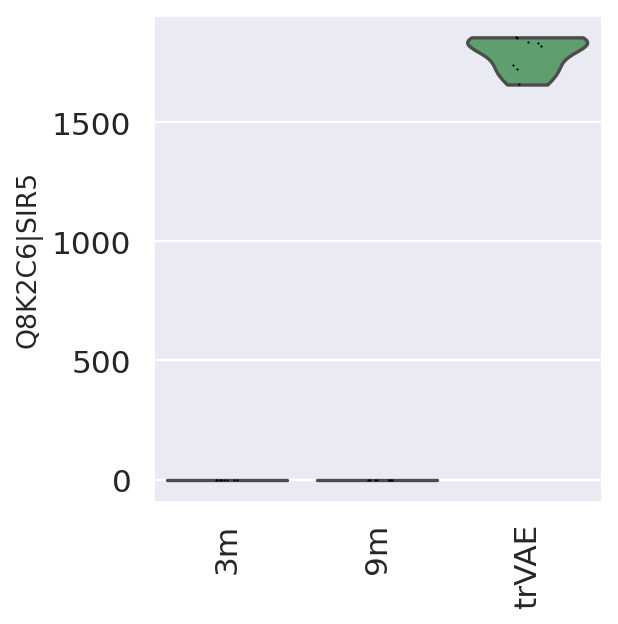

In [2573]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys=protein_up, 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_best_model_cmpr.pdf",
             jitter=True,
            )

In [2574]:
protein_down = down_genes[0]
print(protein_down)

Q9R069|BCAM


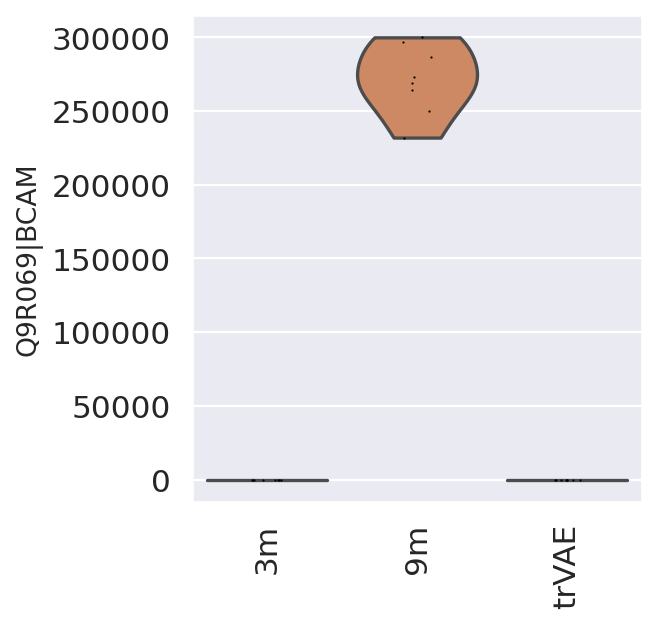

In [2575]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys=protein_down, 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_worst_model_cmpr.pdf",
             jitter=True,
            )

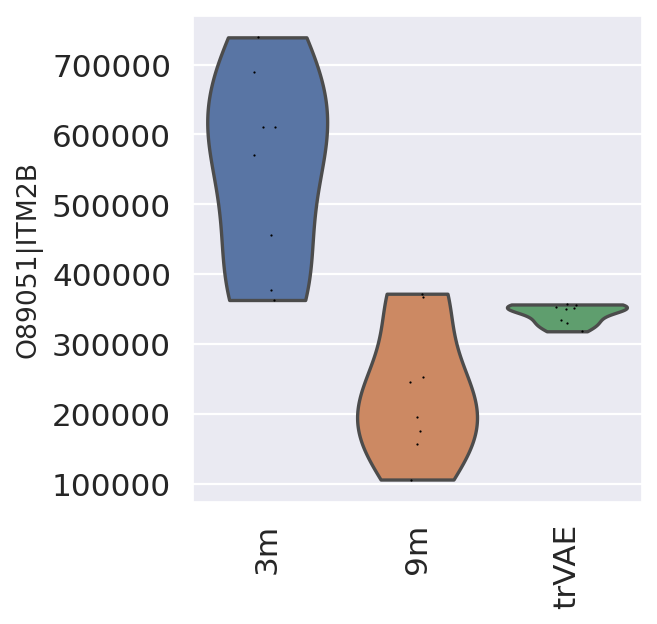

In [2576]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys="O89051|ITM2B", 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_standard_model_cmpr.pdf",
             jitter=True,
            )

### R^2 Plots

In [2577]:
adata_pred = ctrl_adata.concatenate(real_adata, trvae_pred)
#adata_pred.uns['log1p']["base"] = None
adata_pred

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 24 × 2969
    obs: 'Qi ID', 'sex', 'Group', 'Timepoint', 'Validation', 'method', 'batch'

In [2578]:
adata_pred.obs[condition_key].unique()

array(['3m', '9m', '3m_to_9m'], dtype=object)

In [2579]:
#"""
sc.tl.rank_genes_groups(cell_type_adata, reference=target_condition, 
                       groupby=condition_key, groups=[source_condition],
                       key_added='up_reg_genes', n_genes=50)
sc.tl.rank_genes_groups(cell_type_adata, reference=source_condition,
                         groupby=condition_key, groups=[target_condition],
                         key_added='down_reg_genes', n_genes=50)
up_genes = cell_type_adata.uns['up_reg_genes']['names'][source_condition]
down_genes = cell_type_adata.uns['down_reg_genes']['names'][target_condition]
#"""

/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/kojo/miniconda3/envs/trVAE/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: invalid value encountered in true_divide
  self.expm1_func(mean_rest) + 1e-9


In [2580]:
up_genes_pairs = {}
for i in range(50):
    up_genes_pairs[cell_type_adata.uns['up_reg_genes']['names'][source_condition][i]] = cell_type_adata.uns['up_reg_genes']['scores'][source_condition][i]
up_genes_pairs

{'P97493|THIOM': 22.7139,
 'Q9JK81|MYG1': 22.70345,
 'P35802|GPM6A': 20.60463,
 'P63087|PP1G': 20.166275,
 'Q9D4C9|CLVS1': 19.590248,
 'Q8K274|KT3K': 19.567778,
 'P03903|NU4LM': 19.45319,
 'Q99LF4|RTCB': 19.23001,
 'P12970|RL7A': 19.214243,
 'P59672|ANS1A': 19.080194,
 'A2ASS6|TITIN': 19.031738,
 'Q9DBH5|LMAN2': 18.448444,
 'Q8BTI8|SRRM2': 18.36046,
 'Q91WK2|EIF3H': 18.225693,
 'P24529|TY3H': 17.927654,
 'Q8BHE3|ATCAY': 17.694414,
 'Q8R0A5|TCAL3': 17.604855,
 'Q8CIE6|COPA': 17.531096,
 'O08759|UBE3A': 16.929789,
 'P35283|RAB12': 16.814514,
 'Q80ZI6|LRSM1': 16.812801,
 'Q9D1K7|CT027': 16.791613,
 'Q8CHC4|SYNJ1': 16.747381,
 'Q9QXS1|PLEC': 16.708364,
 'Q80TE7|LRRC7': 16.665943,
 'P55194|3BP1': 16.617718,
 'Q9D618|KBTBC': 16.588919,
 'O08585|CLCA': 16.537415,
 'P36916|GNL1': 16.441172,
 'P70335|ROCK1': 16.44033,
 'Q6ZWR6|SYNE1': 16.252293,
 'Q9CR62|M2OM': 16.189981,
 'Q9JIG8|PRAF2': 16.104322,
 'P18872|GNAO': 15.852888,
 'Q8BQP9|R7BP': 15.759781,
 'P61255|RL26': 15.748785,
 'Q9DCN2|NB5R3'

In [2581]:
down_genes_pairs = {}
for i in range(50):
    down_genes_pairs[cell_type_adata.uns['down_reg_genes']['names'][target_condition][i]] = cell_type_adata.uns['down_reg_genes']['scores'][target_condition][i]
down_genes_pairs

{'Q9R069|BCAM': 33.002323,
 'Q8VBX6|MPDZ': 25.822313,
 'Q8BFT9|SVOP': 25.055403,
 'Q9D7X8|GGCT': 22.971518,
 'Q6ZPU9|KBP': 21.230698,
 'Q9JKC8|AP3M1': 20.553158,
 'Q9CZ04|CSN7A': 20.22429,
 'Q8CJH3|PLXB1': 19.5311,
 'Q9D2N9|VP33A': 19.408487,
 'Q8R1T1|CHMP7': 18.811106,
 'Q3UGY8|BIG3': 18.791697,
 'Q9QXK3|COPG2': 18.32131,
 'Q6A065|CE170': 18.151972,
 'Q9D4H2|GCC1': 18.061687,
 'Q8CG70|P3H3': 18.021349,
 'Q3UH66|WNK2': 18.010635,
 'P49446|PTPRE': 17.998648,
 'Q9QX60|DGUOK': 17.929583,
 'P58404|STRN4': 17.644737,
 'Q921H8|THIKA': 17.5593,
 'Q8C5H8|NAKD2': 17.225452,
 'Q6A0A9|F120A': 17.16159,
 'P55258|RAB8A': 16.708015,
 'Q9Z0S6|CLD10': 16.663078,
 'Q8VE62|PAIP1': 16.642096,
 'O70439|STX7': 16.59927,
 'E9Q414|APOB': 16.556269,
 'Q99KK7|DPP3': 16.523207,
 'O88986|KBL': 16.433237,
 'Q8CG79|ASPP2': 16.361828,
 'Q9Z2V5|HDAC6': 16.054163,
 'P56546|CTBP2': 16.046486,
 'Q8R3S6|EXOC1': 15.888116,
 'P11531|DMD': 15.886706,
 'Q6ZWR4|2ABB': 15.882861,
 'Q8BXR9|OSBL6': 15.814648,
 'O88448|KLC2': 15

In [2582]:
top_genes = up_genes.tolist() + down_genes.tolist()

In [2583]:
len(top_genes)

100

In [2584]:
protein_up = up_genes[0]
print(protein_up)

P97493|THIOM


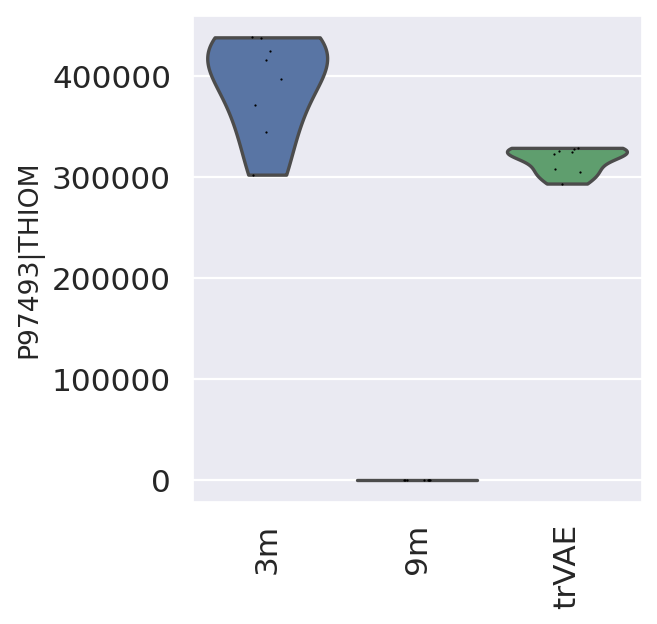

In [2585]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys=protein_up, 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_standard_best_model_cmpr.pdf",
             jitter=True,
            )

In [2586]:
protein_down = down_genes[0]
print(protein_down)

Q9R069|BCAM


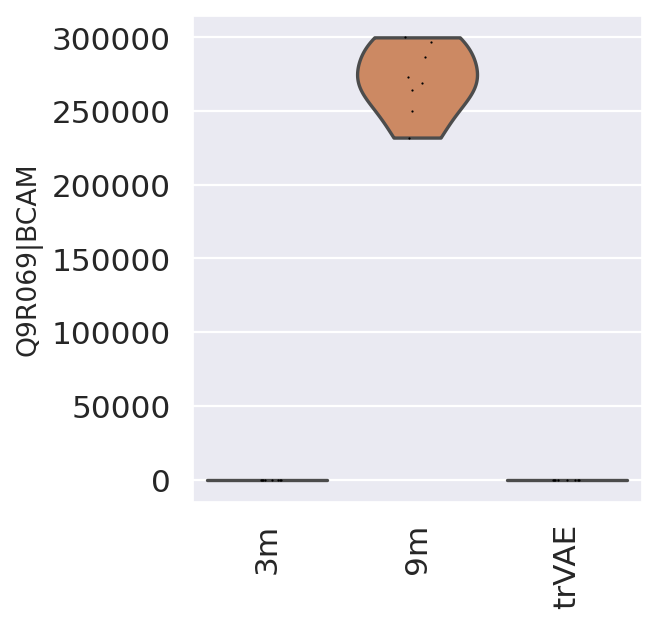

In [2587]:
font = {'family' : 'Arial',
        'size'   : 30}

sc.set_figure_params(fontsize=25)
sns.set()
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.pl.violin(models, 
             keys=protein_down, 
             groupby="method", 
             rotation=90,
             show=True,
             order=models.obs["method"].unique().tolist(),
             color = "#ee0ef0",
             save="_standard_worst_model_cmpr.pdf",
             jitter=True,
            )

In [2588]:
#top_genes = up_genes.tolist() + down_genes.tolist()

reg_mean_top100: 0.4351647951671388
reg_mean_all: 0.34701058446292155


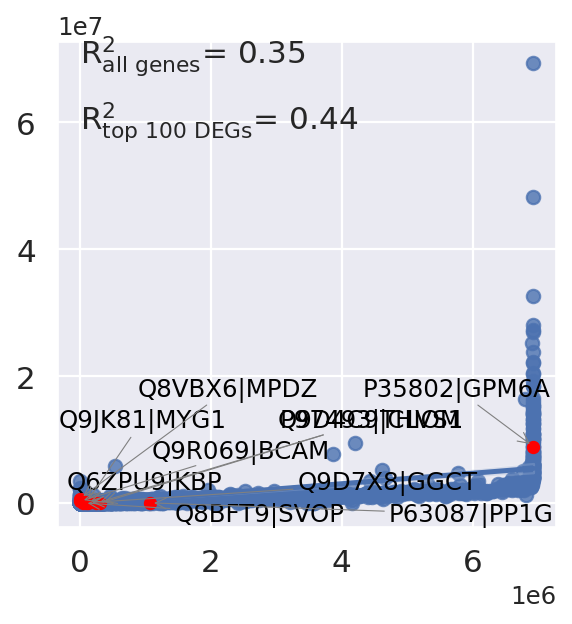

In [2589]:
reptrvae.pl.reg_mean_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"{source_condition}_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, f"trVAE_{specific_cell_type}_{mode}_reg_mean.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.0)

reg_var_top100: 0.48724817744813265
reg_var_all: 0.0450450598546736


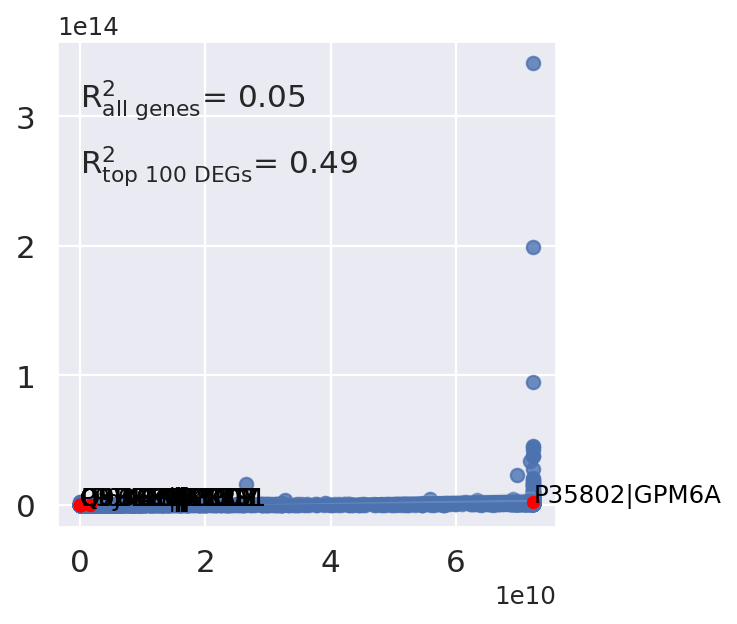

In [2590]:
reptrvae.pl.reg_var_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:5] + top_genes[50:55],
                         condition_key=condition_key,
                         axis_keys={'x': f"{source_condition}_to_{target_condition}", 'y': target_condition},
                         labels={'x': "", 'y': ""},
                         path_to_save=os.path.join(path_to_save, f"trVAE_{specific_cell_type}_{mode}_reg_var.pdf"),
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.1)

In [2591]:
up_genes.tolist()

['P97493|THIOM',
 'Q9JK81|MYG1',
 'P35802|GPM6A',
 'P63087|PP1G',
 'Q9D4C9|CLVS1',
 'Q8K274|KT3K',
 'P03903|NU4LM',
 'Q99LF4|RTCB',
 'P12970|RL7A',
 'P59672|ANS1A',
 'A2ASS6|TITIN',
 'Q9DBH5|LMAN2',
 'Q8BTI8|SRRM2',
 'Q91WK2|EIF3H',
 'P24529|TY3H',
 'Q8BHE3|ATCAY',
 'Q8R0A5|TCAL3',
 'Q8CIE6|COPA',
 'O08759|UBE3A',
 'P35283|RAB12',
 'Q80ZI6|LRSM1',
 'Q9D1K7|CT027',
 'Q8CHC4|SYNJ1',
 'Q9QXS1|PLEC',
 'Q80TE7|LRRC7',
 'P55194|3BP1',
 'Q9D618|KBTBC',
 'O08585|CLCA',
 'P36916|GNL1',
 'P70335|ROCK1',
 'Q6ZWR6|SYNE1',
 'Q9CR62|M2OM',
 'Q9JIG8|PRAF2',
 'P18872|GNAO',
 'Q8BQP9|R7BP',
 'P61255|RL26',
 'Q9DCN2|NB5R3',
 'Q921J2|RHEB',
 'P10630|IF4A2',
 'Q8JZU2|TXTP',
 'O55100|SNG1',
 'Q9JKC6|CEND',
 'O55142|RL35A',
 'O88485|DC1I1',
 'A2A432|CUL4B',
 'P14115|RL27A',
 'P62754|RS6',
 'P63242|IF5A1',
 'O70492|SNX3',
 'Q99KH8|STK24']

In [2592]:
down_genes.tolist()

['Q9R069|BCAM',
 'Q8VBX6|MPDZ',
 'Q8BFT9|SVOP',
 'Q9D7X8|GGCT',
 'Q6ZPU9|KBP',
 'Q9JKC8|AP3M1',
 'Q9CZ04|CSN7A',
 'Q8CJH3|PLXB1',
 'Q9D2N9|VP33A',
 'Q8R1T1|CHMP7',
 'Q3UGY8|BIG3',
 'Q9QXK3|COPG2',
 'Q6A065|CE170',
 'Q9D4H2|GCC1',
 'Q8CG70|P3H3',
 'Q3UH66|WNK2',
 'P49446|PTPRE',
 'Q9QX60|DGUOK',
 'P58404|STRN4',
 'Q921H8|THIKA',
 'Q8C5H8|NAKD2',
 'Q6A0A9|F120A',
 'P55258|RAB8A',
 'Q9Z0S6|CLD10',
 'Q8VE62|PAIP1',
 'O70439|STX7',
 'E9Q414|APOB',
 'Q99KK7|DPP3',
 'O88986|KBL',
 'Q8CG79|ASPP2',
 'Q9Z2V5|HDAC6',
 'P56546|CTBP2',
 'Q8R3S6|EXOC1',
 'P11531|DMD',
 'Q6ZWR4|2ABB',
 'Q8BXR9|OSBL6',
 'O88448|KLC2',
 'Q6ZPE2|MTMR5',
 'P47746|CNR1',
 'Q52KR3|PRUN2',
 'B9EJ86|OSBL8',
 'Q8BPU7|ELMO1',
 'Q8BI08|MAL2',
 'Q91VM5|RMXL1',
 'P70236|MP2K6',
 'Q8C7E9|CSTFT',
 'Q99LD9|EI2BB',
 'Q60972|RBBP4',
 'Q9QYH6|MAGD1',
 'Q9CRD4|DBND2']